<b> IMPORTS

In [4]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from xgboost import XGBClassifier
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

<b> GATHER & ASSEES DATA

In [5]:
# Check the mpl version (3.1.1 caused issues with seaborn)
matplotlib.__version__

'3.1.3'

In [6]:
# Load the data
df = pd.read_csv('data-final.csv', sep='\t')

In [7]:
# Inspect the data
df.head(1)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991


In [8]:
# Inspect the metadata
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015341 entries, 0 to 1015340
Columns: 110 entries, EXT1 to long_appx_lots_of_err
dtypes: float64(104), int64(2), object(4)
memory usage: 852.1+ MB


In [9]:
# Inspect the data shape
print('Number of rows:',df.shape[0])
print('Number of cols:',df.shape[1])

Number of rows: 1015341
Number of cols: 110


In [10]:
# Classify the columns to categorical and numerical
num_cols = df._get_numeric_data().columns
cat_cols = [col for col in df.columns if col not in num_cols]

In [11]:
print('Number of columns:',len(df.columns))
print('Numerical columns:',len(num_cols))
print('Categorical columns:',len(cat_cols))

Number of columns: 110
Numerical columns: 106
Categorical columns: 4


<b> CLEAN THE DATA

In [12]:
# First step of cleaning- IPC.
# Limit the analysis to IPC =1 to get rid of duplicated submissions.
"""
As per Kaggle dataset description:
The number of records from the user's IP address in the dataset. 
For max cleanliness, only use records where this value is 1. 
High values can be because of shared networks (e.g. entire universities) or multiple submissions
"""
df = df.loc[df['IPC']==1]

In [13]:
# List the redundant cols such as response times and longitude and latitudee
drop_cols=list(df.columns[50:107])+list(df.columns[-2:])

In [14]:
# Drop the redundant cols
df=df.drop((drop_cols), axis=1)

In [15]:
# List the number of unique countries, count them
countries = df['country'].unique()
len(countries)

222

In [16]:
# A list of all EU countries, count them
EU = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]
len(EU)

28

In [17]:
# Check if all EU countries are in the data
intersection = set(EU).intersection(set(countries))
len(intersection)

28

In [18]:
# Limit the analysis to EU countries
df = df.loc[df['country'].isin(EU)]

In [19]:
# Count responses by country
df['country'].value_counts()[:5]

GB    49803
DE    12327
NL     7752
SE     7442
FR     5121
Name: country, dtype: int64

In [20]:
# This gives us percentage of responses from each country
df['country'].value_counts(normalize=True) * 100

GB    38.191020
DE     9.452858
NL     5.944557
SE     5.706836
FR     3.926997
IT     3.397109
ES     3.337295
PL     3.223803
IE     3.154787
FI     2.940071
DK     2.934703
RO     2.578122
BE     2.144856
GR     1.755301
PT     1.707757
AT     1.499942
HR     1.491507
CZ     1.214677
HU     1.021433
BG     0.871899
LT     0.719298
EE     0.661018
SK     0.620375
SI     0.565929
LV     0.361949
MT     0.246923
CY     0.184809
LU     0.144166
Name: country, dtype: float64

In [21]:
# Check for missing data.
df.isna().mean()[:5]

EXT1    0.000798
EXT2    0.000798
EXT3    0.000798
EXT4    0.000798
EXT5    0.000798
dtype: float64

In [22]:
# Drop the missing data
df = df.dropna()

In [23]:
df.isna().mean()[:5]

EXT1    0.0
EXT2    0.0
EXT3    0.0
EXT4    0.0
EXT5    0.0
dtype: float64

In [24]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,1.0,2.0,1.0,4.0,2.0,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2.0,5.0,2.0,3.0,1.0,4.0,4.0,3.0,3.0,GB
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,1.0,5.0,1.0,3.0,1.0,5.0,4.0,5.0,2.0,SE
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,1.0,5.0,1.0,4.0,1.0,5.0,2.0,5.0,5.0,GB


<b> FEATURE ENGINEERING

In [25]:
# Create an aggregated feature for each of the five personality dimensions.
# They will average the 10 answers across the dimension.

# Extraversion 
EXT = list(df.columns[:10])
# Emotional Stability
EST = list(df.columns[10:20])
# Agreeableness
AGR = list(df.columns[20:30])
# Conscientiousness
CSN = list(df.columns[30:40])
# Openness
OPN = list(df.columns[40:50])

dimensions = [EXT,EST,AGR,CSN,OPN]
dimension_averages=["extraversion","emotional_stability",
       "agreeableness","conscientiousness","openness"]

In [26]:
for d in range(len(dimensions)):
    df[dimension_averages[d]] = df[dimensions[d]].mean(axis=1)

<b> ANALYSE THE DATA

In [27]:
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7,OPN8,OPN9,OPN10,country,extraversion,emotional_stability,agreeableness,conscientiousness,openness
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,3.0,4.0,5.0,GB,3.0,2.4,3.1,3.2,3.3
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,3.0,4.0,4.0,GB,2.9,2.6,2.8,2.8,3.1
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,4.0,4.0,3.0,3.0,GB,2.6,2.7,3.2,2.7,3.1
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,5.0,4.0,5.0,2.0,SE,3.0,2.2,2.8,2.9,3.2
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,5.0,2.0,5.0,5.0,GB,2.8,2.8,2.9,2.5,3.3


In [28]:
# Analyse the aggregated features
df[dimension_averages].describe()

,extraversion,emotional_stability,agreeableness,conscientiousness,openness
count,130301.000000,130301.000000,130301.000000,130301.000000,130301.000000
mean,2.985394,3.065468,3.105783,3.088718,3.307225
std,0.357523,0.650218,0.375960,0.407831,0.398023
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.800000,2.600000,2.900000,2.800000,3.100000
50%,3.000000,3.100000,3.100000,3.100000,3.300000
75%,3.200000,3.500000,3.300000,3.300000,3.600000
max,5.000000,5.000000,5.000000,5.000000,5.000000


<b> VISUALISE THE DATA

In [26]:
corr=df[dimension_averages].corr()

Text(0.5, 1.0, 'Average characteristics of European citizens')

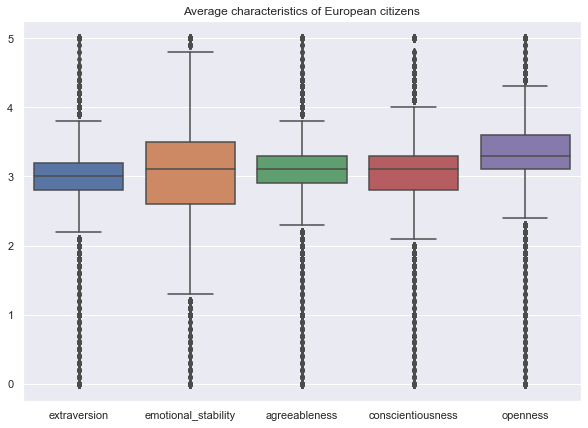

In [37]:
# Use a boxlot to visualise the 5 variables
# This method will give us a good overview of the distribution across the variables
sns.set_style("darkgrid")
sns.boxplot(data=df[dimension_averages]);
sns.set(rc={'figure.figsize':(20,7)})
plt.title("Average characteristics of European citizens")

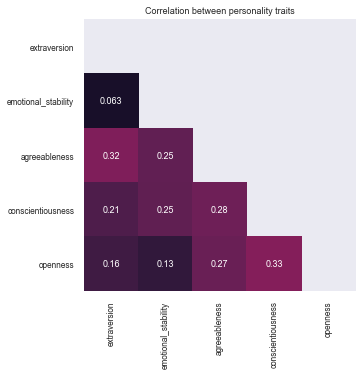

In [32]:
# Visualise the correlation
mask = np.triu(corr)
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale=0.75)
sns.heatmap(df[dimension_averages].corr(),
            vmin=0,
            vmax=1,
            annot = True,
            square=True, 
            mask=mask,
            cbar=False)
plt.title('Correlation between personality traits')
plt.show()

In [29]:
# Subset df to only those with country GB, PL
gb = df.loc[df['country']=="GB"]
pl = df.loc[df['country']=="PL"]

In [30]:
# Limit the analysis to two countries and averages across 5 dimensions
pl = pl[pl.columns[-6:]]
gb = gb[gb.columns[-6:]]

In [31]:
def transpose_table(df, col_list):
    """
    INPUT 
        df - a dataframe holding the col_list columns
        col_list- columns that we want to transpose into rows
        
    OUTPUT
        new_df- a transposed dataframe.
    """
    new_df = defaultdict(int)
    for i in col_list:
        new_df[i]=df[i].mean()
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.rename(columns={'index': 'personality', 0: 'average'}, inplace=True)
    new_df.set_index('personality', inplace=True)
    return new_df 

In [32]:
dimension_averages

['extraversion',
 'emotional_stability',
 'agreeableness',
 'conscientiousness',
 'openness']

In [31]:
gb_avg = transpose_table(gb,dimension_averages)
pl_avg = transpose_table(pl,dimension_averages)
comp_df = pd.merge(gb_avg, pl_avg, left_index=True, right_index=True)
comp_df.columns = ['gb_avg', 'pl_avg']
comp_df['value_difference'] = comp_df['gb_avg'] - comp_df['pl_avg']
comp_df.style.bar(subset=['value_difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,gb_avg,pl_avg,value_difference
personality,,,
extraversion,2.997948,2.928837,0.069112
emotional_stability,3.107214,3.160671,-0.053457
agreeableness,3.116576,3.087223,0.029352
conscientiousness,3.074450,3.122365,-0.047915
openness,3.304419,3.312515,-0.008096


In [33]:
df

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7,OPN8,OPN9,OPN10,country,extraversion,emotional_stability,agreeableness,conscientiousness,openness
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,5.0,3.0,4.0,5.0,GB,3.0,2.4,3.1,3.2,3.3
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,5.0,3.0,4.0,4.0,GB,2.9,2.6,2.8,2.8,3.1
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,4.0,4.0,3.0,3.0,GB,2.6,2.7,3.2,2.7,3.1
5,3.0,3.0,4.0,2.0,4.0,2.0,2.0,3.0,3.0,4.0,...,5.0,4.0,5.0,2.0,SE,3.0,2.2,2.8,2.9,3.2
8,2.0,2.0,3.0,3.0,4.0,2.0,2.0,2.0,4.0,4.0,...,5.0,2.0,5.0,5.0,GB,2.8,2.8,2.9,2.5,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015304,2.0,5.0,3.0,4.0,3.0,4.0,3.0,4.0,5.0,5.0,...,3.0,3.0,4.0,2.0,IT,3.8,2.5,2.7,2.9,2.9
1015317,1.0,1.0,5.0,2.0,5.0,1.0,1.0,1.0,5.0,1.0,...,4.0,2.0,1.0,3.0,GB,2.3,3.0,3.0,2.8,2.2
1015326,3.0,1.0,3.0,3.0,4.0,1.0,5.0,3.0,3.0,2.0,...,5.0,5.0,5.0,5.0,GB,2.8,2.9,3.2,3.4,3.8
1015329,3.0,2.0,4.0,3.0,4.0,2.0,2.0,3.0,3.0,4.0,...,4.0,2.0,5.0,5.0,GB,3.0,2.6,3.4,2.7,3.3


<b> MODEL : XGBOOST

In [34]:
# Copy the dataframe
df_ml = df

# Add binary column to indicate if Great Britain 
df_ml['is_gb'] = df_ml['country'].apply(lambda x: 1 if x =='GB' else 0)

# Delete old column indicating country
df_ml = df_ml.drop(columns='country')

# Shuffle the data to ensure that split is fair
df_ml = df_ml.sample(n=len(df_ml),random_state=42)

In [35]:
# Select the dependent variable
Y = df_ml['is_gb']
X = df_ml.drop('is_gb',axis=1)

In [36]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [37]:
# Instantiate the model
model = XGBClassifier(learning_rate=0.1, max_depth=6,
              min_child_weight=1,
              n_estimators=180, 
              objective='binary:logistic', 
                random_state=42, nthread=1)

# fit model to training data
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [38]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.03%


In [44]:
# Find optimal threshold
thresholds=[0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.55, 0.46, 0.47, 0.48, 0.49, 0.5]
for t in thresholds:
    predictions=model.predict_proba(X_test)[:,1]>t
    print("AUC for threshold",t,":",
         roc_auc_score(y_test, predictions))
    accuracy = accuracy_score(y_test, predictions)
    print("XGB Classifier accuracy: %.2f%%" % (accuracy * 100.0))

AUC for threshold 0.37 : 0.6631436299242484
XGB Classifier accuracy: 65.78%
AUC for threshold 0.38 : 0.664326253989359
XGB Classifier accuracy: 66.39%
AUC for threshold 0.39 : 0.6649735350257662
XGB Classifier accuracy: 66.93%
AUC for threshold 0.4 : 0.6644446638681132
XGB Classifier accuracy: 67.31%
AUC for threshold 0.41 : 0.6629485062996762
XGB Classifier accuracy: 67.65%
AUC for threshold 0.42 : 0.6610254870360062
XGB Classifier accuracy: 67.91%
AUC for threshold 0.43 : 0.6597333671786827
XGB Classifier accuracy: 68.22%
AUC for threshold 0.44 : 0.6578949612886302
XGB Classifier accuracy: 68.46%
AUC for threshold 0.55 : 0.6196947752894983
XGB Classifier accuracy: 68.75%
AUC for threshold 0.46 : 0.6519254727509243
XGB Classifier accuracy: 68.70%
AUC for threshold 0.47 : 0.6501846051903166
XGB Classifier accuracy: 68.93%
AUC for threshold 0.48 : 0.6457480671367294
XGB Classifier accuracy: 68.87%
AUC for threshold 0.49 : 0.6438450364675374
XGB Classifier accuracy: 69.05%
AUC for thresh

In [45]:
# Check the most important features
importance = model.get_booster().get_score(importance_type= 'gain')
sorted(importance.items(), key=lambda x:x[1],reverse=True)[:3]

[('EST9', 40.26071294909095),
 ('CSN8', 39.128417838525614),
 ('AGR1', 34.86451489114784)]

In [73]:
gb_df = df_ml.loc[df['is_gb']==1]
not_gb_df = df_ml.loc[df['is_gb']==0]

gb_df = transpose_table(gb_df,['EST9','CSN8','AGR1'])
not_gb_df = transpose_table(not_gb_df,comp_metrics)
comp_df = pd.merge(gb_df, not_gb_df, left_index=True, right_index=True)
comp_df.columns = ['gb_avg','not_gb_avg']
comp_df['value_difference'] = comp_df['gb_avg'] - comp_df['not_gb_avg']
comp_df.style.bar(subset=['value_difference'], align='mid', color=['#d65f5f', '#5fba7d'])

,gb_avg,not_gb_avg,value_difference
personality,,,
EST9,3.303145,2.994425,0.308720
CSN8,2.534794,2.753576,-0.218783
AGR1,2.183663,2.459621,-0.275957


In [ ]:
# I get irritated easily.
# I shirk my duties.
# I feel little concern for others.